## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project: 
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)

## Team members

* Luis Mauricio Castro Gutiérrez - A01795088
* Jesus Ulises Avelar Perez - A01795325
* Luis Daniel Barrionuevo Llerena - A00826282
* Kevin Balderas Sánchez - A01795149
* José Arturo Valdivia Rivero - A01795395

#### Import libraries

In [1]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle
plt.style.use('ggplot')

#### Load file

In [2]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
PATH = './glove.6B.50d.txt'
emb_dim = 50

In [32]:
# Create dictionary with embeddings
def create_emb_dictionary(path):
    dict_emb = {}
    #Lectura de archivo 
    with open(PATH, encoding='utf8') as f:
        #Retorna un arreglo de lineas del archivo, con '\n' como carácter final
        contents = f.readlines()
        for index in range(len(contents)):
            #De cada linea retornada, iteramos y dividimos por ' ' para obtener otra sublista
            content_list = [contents[index]][0].split(' ')
            #Una vez teniendo la sublista, el primer elemento es la palabra y los demás son los valores de embeddings
            dict_emb[content_list[0]] = content_list[1:]
            #El último reemplazamos el '\n' por ' ' para tener sólo números en nuestro dict final
            dict_emb[content_list[0]][-1] = dict_emb[content_list[0]][-1].replace('\n', '') 
    return dict_emb

In [33]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)

In [35]:
# Serialize
#with open('embeddings_dict_50D.pkl', 'wb') as f:
#    pickle.dump(embeddings_dict, f)

# Deserialize
with open('embeddings_dict_50D.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

#### See some embeddings

In [36]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [37]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [39]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func = PCA):
    embeddings = np.zeros((len(words2show), emb_dim)) # Example -> 20 words x 50 embedding
    words2idx = {w:i for i, w in enumerate(words2show)} #Example -> {'burger':0, 'tortilla':1}
    emb_dict = {}
    for word in words2show:
        idx = words2idx[word] #Obtenemos indice de palabra 
        embeddings[idx] = embeddings_dict[word] #Asignamos cada palabra a cada embedding, de dimension 50
        
    #Graficamos embeddings con cada una de las 2 componentes finales
    vectors_2d = func(n_components=2, random_state=43).fit_transform(embeddings)
    plt.figure(figsize=(20,10))
    plt.scatter(vectors_2d[:,0], vectors_2d[:,1], c='red', edgecolors='r')
    
    #Agregamos anotación a cada punto graficado
    for i, word in enumerate(words):
        plt.annotate(word, (vectors_2d[i,0], vectors_2d[i,1]))
    plt.show()

In [40]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips', 
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


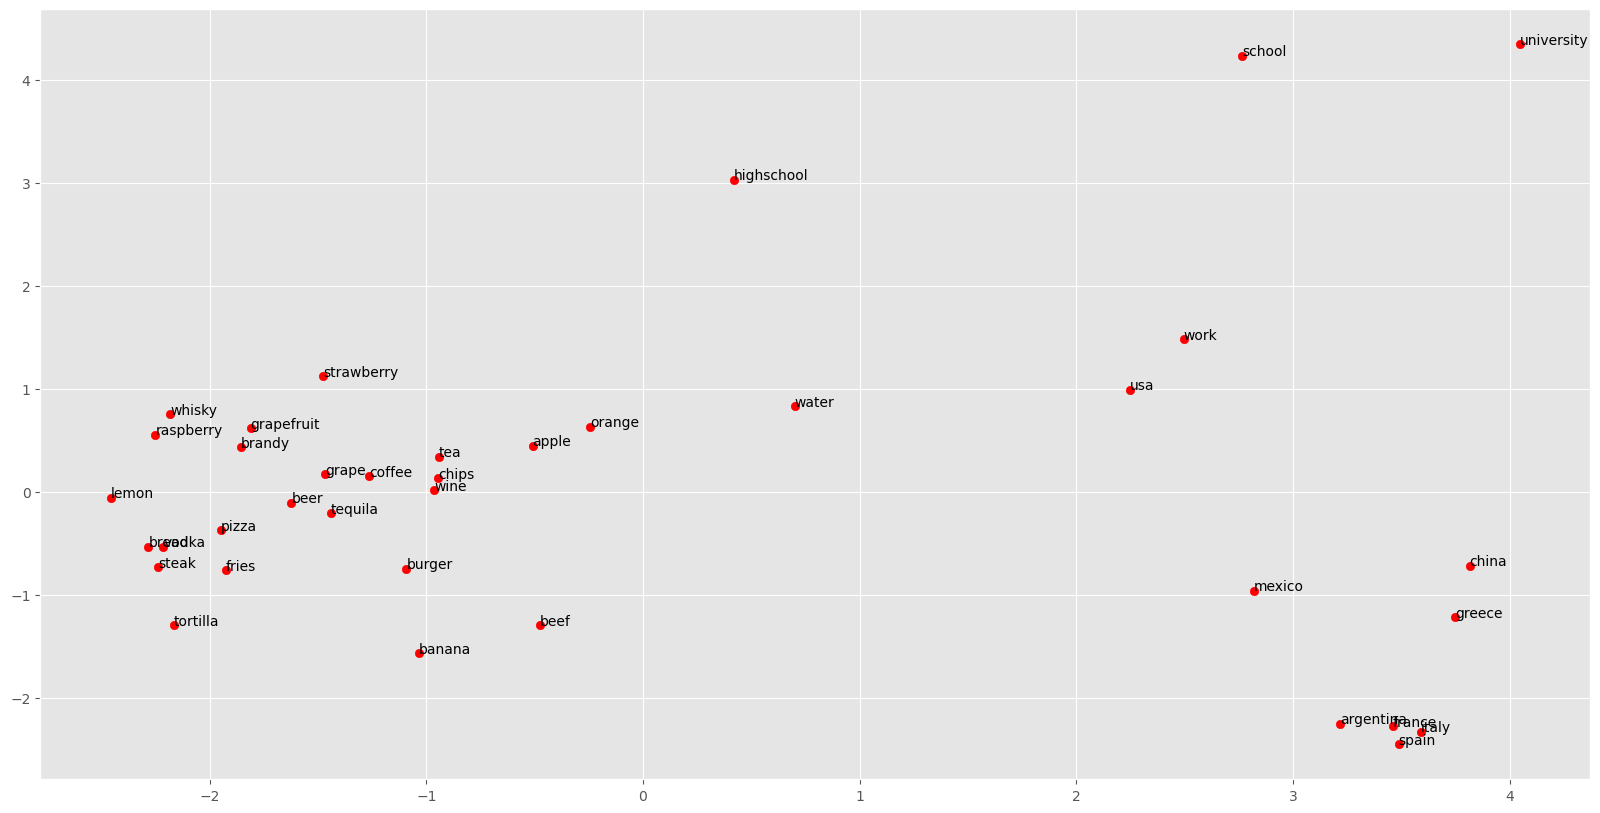

In [41]:
# PCA dimensionality reduction for visualization
plot_embeddings(PATH, words, emb_dim, embeddings_dict, PCA)

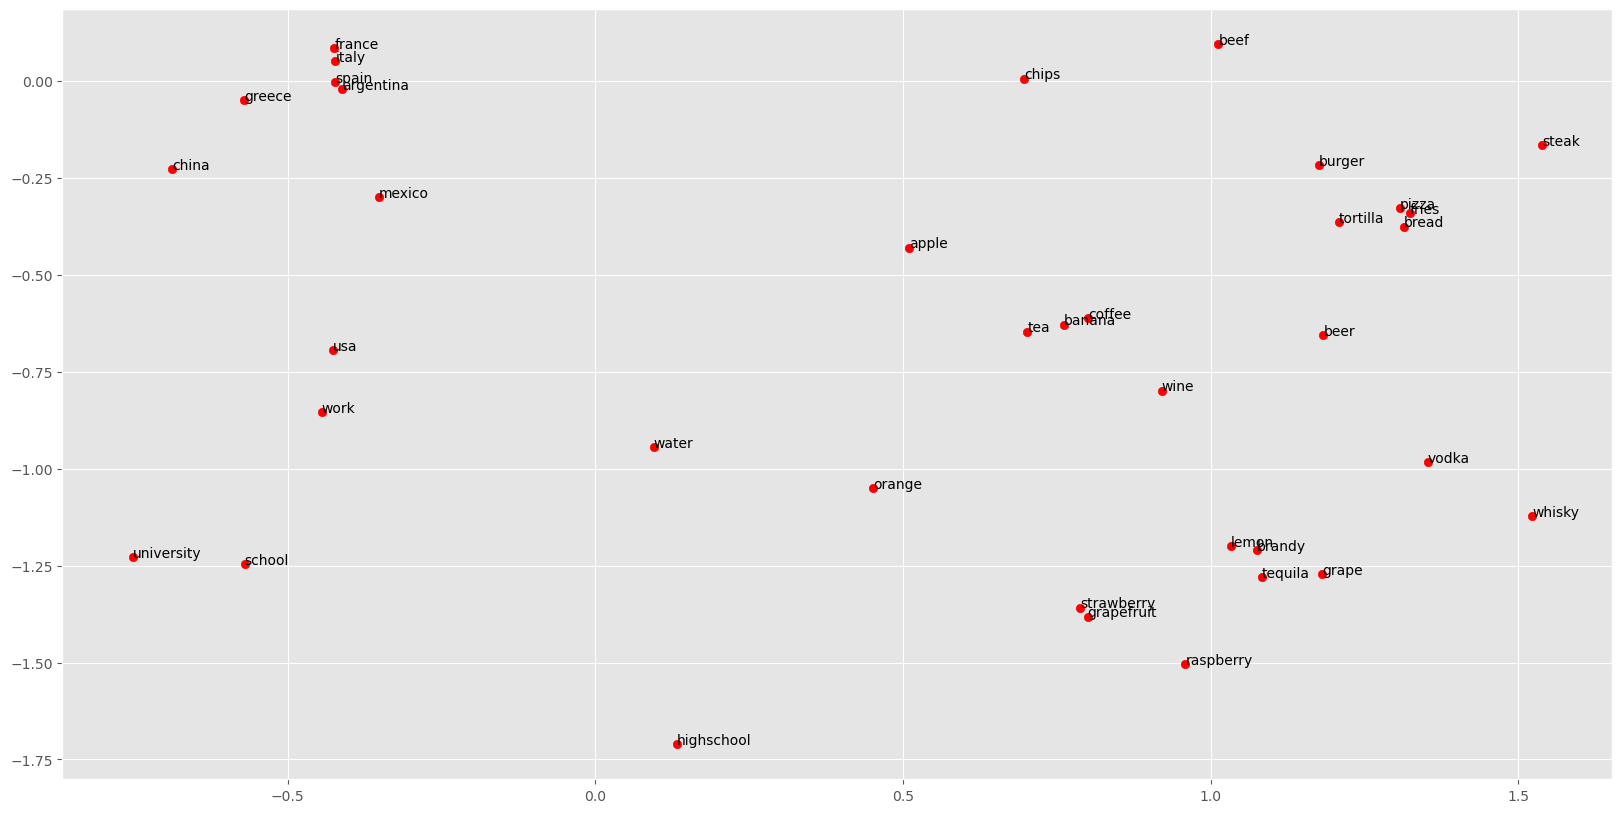

In [43]:
# t-SNE dimensionality reduction for visualization
embeddings = plot_embeddings(PATH, words, emb_dim, embeddings_dict, TSNE)

### Let us compute analogies

In [121]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
    #Separate each dictionary key-pair values into words and values
    words, values_str = list(embeddings_dict.keys()) , list(embeddings_dict.values())
    values_num = []
    #Change the datatype for the values, because it's in the form '18.5' but we need it as a float
    for i in range(len(values_str)):
        values_num.append([float(i) for i in values_str[i]])
    #Just iterate to conveert to a numpy array
    nex_dict = {}
    for index in range(len(values_num)):
        nex_dict[words[index]] = np.array(values_num[index])
    #We iterated through each word and calculate similarity in the form: word1 + word2 = word 3 +word 4
    #Taking into account that (word2-word1)-(word4-word3) = 0(Approximately)
    #Then we just applied the norm from numpy, but we could instead usead cosine_similarity or any other score
    word4 = None
    maximum_similarity = float('inf')
    temp = nex_dict[word2] - nex_dict[word1]
    
    for i in words: 
        if i in [word1,word2,word3]: 
            continue
        wvec = nex_dict[i] 
        similarity = norm(temp - (wvec-nex_dict[word3]))
        #Here we maximize the metric such that the result is the lowes possible in order to get that 0 metionated above
        if similarity < maximum_similarity: 
            maximum_similarity = similarity 
            word4 = i  
    return f'{word1} is to {word2} as {word3} is to **{word4}**.'


In [122]:
analogy('man', 'king', 'woman', embeddings_dict)

'man is to king as woman is to **queen**.'

In [151]:
# most similar
def find_most_similar(word, embeddings_dict, top_n=10):
    #Same as the previous function, we split the key-value pairs into new arrays, now with the correct datatype
    words, values_str = list(embeddings_dict.keys()) , list(embeddings_dict.values())
    values_num = []
    for i in range(len(values_str)):
        values_num.append([float(i) for i in values_str[i]])
    nex_dict = {}
    #Here we just converted into np.array, it was loaded as a list from the file
    for index in range(len(values_num)):
        nex_dict[words[index]] = np.array(values_num[index])
    #We apply the norm function between each pair of embedding-word values
    #Then inside a new dictionary we map every word to every result
    #At the end of the loop we have the similarity, then we only get the top_n values, based on value
    word2 = None
    final_dict = {}
    for i in words: 
        if i ==word:
            continue
        #Calculated similarity with distance (norm)
        similarity = norm(nex_dict[i] - nex_dict[word])
        final_dict[i] = similarity
    sorted_items = sorted(final_dict.items(), key=lambda x:x[1])
    
    print(sorted_items[:top_n])
    return sorted_items[:top_n]

In [152]:
most_similar = find_most_similar('mexico', embeddings_dict)

[('venezuela', 2.843226083344738), ('peru', 2.865439744929608), ('mexican', 2.8677629725708957), ('chile', 2.9099873696318785), ('colombia', 2.9245772849471865), ('puerto', 3.012550558178659), ('rico', 3.0694568344419535), ('guatemala', 3.1164836764344686), ('panama', 3.139428767928054), ('costa', 3.1808133321784005)]


In [153]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> venezuela
2 ---> peru
3 ---> mexican
4 ---> chile
5 ---> colombia
6 ---> puerto
7 ---> rico
8 ---> guatemala
9 ---> panama
10 ---> costa


### Conclusions
   * We could achieve different resuls based on the metric used to calculate similarity and changing the embeddings used (we used here the 50B version, 50 embeddings for each word)
   
   * Since the beginning we observed the data type could be a problem because we got the information from the file, coming as a text or string format, so we had to convert them into floats again, so a helper function could be applied here.
   
   * Calculating the most similar word for 'mexico' we got 'venezuela', 'peru' and 'mexican' as top 3 most similar words, but in the videoclass provided by the professor we noticed the most similar one was 'mexican'. This was result of the metric used (we used the norm function, which is used to calculate distance between points and we also used the 50B embeddings version)
   * For the visualization part of this task, we got similar plots, but the scales and numbers are different (that's because we used PCA and TSNE), but we observed similar cumulus for similar words 